# **Data - 나영**

### **Load Modules**

In [12]:
# Utils
import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import os
import torchvision.models as models
from utility.early_stopping import EarlyStopping
# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler


import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from tensorboardX import SummaryWriter

# sklearn
from sklearn.metrics import confusion_matrix, classification_report

**Seed Setting**

In [13]:
random.seed(0)

**Device Setting**

In [14]:
# 디바이스 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

**Set Hyperparameters**

In [15]:
batch_size = 128
num_epochs = 20
learning_rate = 0.001
momentum = 0.9

# Data Preprocessing

In [16]:
train_val_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(),
    transforms.RandomCrop(32, padding=4), 
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
])

### **Load Data**

**Splitting th training data**

In [17]:
train_val_data = datasets.CIFAR100(root='./data', train=True, download=True, transform=train_val_transform)
test_data = datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [18]:
# train_data = datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transform)
# test_data = datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transform)

In [19]:
# train 데이터를 train/val로 나누기
num_train = len(train_val_data)
indices = list(range(num_train))
split = int(np.floor(0.2 * num_train))  # validation 데이터를 20%로 설정

np.random.shuffle(indices)
train_idx, val_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

**Define DataLoader**

In [20]:
train_loader = DataLoader(train_val_data, batch_size=batch_size, sampler=train_sampler, num_workers=2)
val_loader = DataLoader(train_val_data, batch_size=batch_size, sampler=val_sampler, num_workers=2)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

# **Model - 하연**

models 폴더에 만들고 import 하는 식으로 해주세요

**Training Loop**

In [21]:
# # models 폴더의 경로 추가
# sys.path.append('./models')

print("use:", device)

# 모델 import 하기
from models.resnetRS import ResNetRS18
from models import resnet

# 모델 초기화
net = resnet.resnet18()

# 모델을 GPU로 이동
net.to(device)

# 모델 구조 출력
print(summary(net, (3, 224, 224)))

use: cuda:0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,728
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,864
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
            Conv2d-7         [-1, 64, 224, 224]          36,864
       BatchNorm2d-8         [-1, 64, 224, 224]             128
        BasicBlock-9         [-1, 64, 224, 224]               0
           Conv2d-10         [-1, 64, 224, 224]          36,864
      BatchNorm2d-11         [-1, 64, 224, 224]             128
             ReLU-12         [-1, 64, 224, 224]               0
           Conv2d-13         [-1, 64, 224, 224]          36,864
      BatchNorm2d-14       

### **Loss and Optimizer**

In [22]:
# 손실함수 초기화
criterion = nn.CrossEntropyLoss()

# 옵티마이저 초기화
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

# 옵티마이저의 state_dict 출력
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'foreach': None, 'differentiable': False, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]}]


# **Train - 하연**

### **Model Train**

In [23]:
writer = SummaryWriter("./runs/resnet_18/tensorboard")

In [24]:
# save_path = "./runs/resnet_18/checkpoints"
# early_stopping = EarlyStopping(save_path)
early_stopping = EarlyStopping(patience=5, verbose=True)

In [25]:
# 모델 학습 함수
def train_model(model, trainloader, criterion, optimizer, num_epochs=25):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch_idx, (inputs, labels) in enumerate(trainloader):
            labels = labels.type(torch.LongTensor).to(device)  # CPU에서 long type tensor로 변환
            inputs = inputs.to(device)

            optimizer.zero_grad()

            # 모델 예측
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # 역전파 및 최적화
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

            # 30번째 배치마다 상태 출력
            if (batch_idx + 1) % 30 == 0:
                print(f"Batch [{batch_idx+1}/{len(trainloader)}], Loss: {loss.item():.4f}")

        # Epoch당 평균 손실 계산 및 출력
        epoch_loss = running_loss / len(trainloader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

        # Early Stopping 체크
        early_stopping(epoch_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

**Model Test**

In [26]:
# 모델 평가 및 테스트 함수 (superclass 예측 포함)
def test_model(model, testloader, criterion, epoch):
    model.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # 모델 예측
            outputs = model(inputs)
            test_loss += criterion(outputs, labels).item() * inputs.size(0)
            
            # 예측 결과 저장 및 정확도 계산
            pred = outputs.argmax(dim=1)
            correct += (pred == labels).sum().item()

            # TensorBoard에 테스트 손실 및 정확도 기록
            writer.add_scalar("Test Loss", test_loss / len(testloader.dataset), epoch)
            writer.add_scalar("Test Accuracy", correct / len(testloader.dataset), epoch)

    # 평균 손실 및 정확도 계산
    test_loss /= len(testloader.dataset)
    accuracy = correct / len(testloader.dataset)
    
    return test_loss, accuracy

### **Per-Epoch Activity**

In [27]:
# Per-Epoch Activity 코드
for epoch in tqdm(range(1, num_epochs + 1)):
    # 모델 학습
    train_model(net, train_loader, criterion, optimizer, num_epochs=num_epochs)
    
    # 테스트 평가
    test_loss, test_accuracy = test_model(net, test_loader, criterion, epoch)
    
    # TensorBoard에 테스트 결과 기록
    writer.add_scalar("Test Loss", test_loss, epoch)
    writer.add_scalar("Test Accuracy", test_accuracy, epoch)

    # 현재 epoch 결과 출력
    print(f"Epoch [{epoch}/{num_epochs}]   Loss: {test_loss:.4f}   Accuracy: {test_accuracy*100:.2f}%")

# TensorBoard writer 닫기
writer.close()

  0%|                                                    | 0/20 [00:00<?, ?it/s]

Batch [30/313], Loss: 4.5407
Batch [60/313], Loss: 4.4200
Batch [90/313], Loss: 4.2457
Batch [120/313], Loss: 4.2392
Batch [150/313], Loss: 3.9844
Batch [180/313], Loss: 4.0849
Batch [210/313], Loss: 3.9340
Batch [240/313], Loss: 3.8321
Batch [270/313], Loss: 3.8538
Batch [300/313], Loss: 3.8021
Epoch [1/20], Loss: 3.2889
Validation loss decreased (inf --> 3.288852).  Saving model ...
Batch [30/313], Loss: 3.9197
Batch [60/313], Loss: 3.7285
Batch [90/313], Loss: 3.4634
Batch [120/313], Loss: 3.6148
Batch [150/313], Loss: 3.5735
Batch [180/313], Loss: 3.5115
Batch [210/313], Loss: 3.5495
Batch [240/313], Loss: 3.5395
Batch [270/313], Loss: 3.4256
Batch [300/313], Loss: 3.3767
Epoch [2/20], Loss: 2.8679
Validation loss decreased (3.288852 --> 2.867903).  Saving model ...
Batch [30/313], Loss: 3.6272
Batch [60/313], Loss: 3.4037
Batch [90/313], Loss: 3.3992
Batch [120/313], Loss: 3.1510
Batch [150/313], Loss: 3.3535
Batch [180/313], Loss: 3.2254
Batch [210/313], Loss: 3.2571
Batch [240/3

  5%|██                                       | 1/20 [03:11<1:00:40, 191.58s/it]

Epoch [1/20]   Loss: 1.6968   Accuracy: 54.29%
Batch [30/313], Loss: 1.2417
Batch [60/313], Loss: 1.0816
Batch [90/313], Loss: 1.0654
Batch [120/313], Loss: 1.3992
Batch [150/313], Loss: 1.0646
Batch [180/313], Loss: 1.3713
Batch [210/313], Loss: 1.1942
Batch [240/313], Loss: 1.3772
Batch [270/313], Loss: 1.1415
Batch [300/313], Loss: 1.1031
Epoch [1/20], Loss: 1.0047
Validation loss decreased (1.041417 --> 1.004664).  Saving model ...
Batch [30/313], Loss: 1.1067
Batch [60/313], Loss: 1.2287
Batch [90/313], Loss: 1.3281
Batch [120/313], Loss: 1.0633
Batch [150/313], Loss: 1.2228
Batch [180/313], Loss: 1.1257
Batch [210/313], Loss: 1.1975
Batch [240/313], Loss: 1.3296
Batch [270/313], Loss: 1.1858
Batch [300/313], Loss: 1.1422
Epoch [2/20], Loss: 0.9582
Validation loss decreased (1.004664 --> 0.958238).  Saving model ...
Batch [30/313], Loss: 1.0673
Batch [60/313], Loss: 1.1804
Batch [90/313], Loss: 1.2722
Batch [120/313], Loss: 1.0283
Batch [150/313], Loss: 1.0808
Batch [180/313], Los

 10%|████                                     | 2/20 [09:14<1:27:46, 292.57s/it]

Epoch [2/20]   Loss: 1.5548   Accuracy: 60.67%
Batch [30/313], Loss: 0.4392
Batch [60/313], Loss: 0.4752
Batch [90/313], Loss: 0.3773
Batch [120/313], Loss: 0.5768
Batch [150/313], Loss: 0.4533
Batch [180/313], Loss: 0.5021
Batch [210/313], Loss: 0.4569
Batch [240/313], Loss: 0.5794
Batch [270/313], Loss: 0.4973
Batch [300/313], Loss: 0.6400
Epoch [1/20], Loss: 0.4130
Validation loss decreased (0.428892 --> 0.412984).  Saving model ...
Batch [30/313], Loss: 0.4543
Batch [60/313], Loss: 0.5295
Batch [90/313], Loss: 0.5101
Batch [120/313], Loss: 0.4314
Batch [150/313], Loss: 0.4476
Batch [180/313], Loss: 0.4476
Batch [210/313], Loss: 0.5347
Batch [240/313], Loss: 0.3987
Batch [270/313], Loss: 0.4452
Batch [300/313], Loss: 0.6242
Epoch [2/20], Loss: 0.3863
Validation loss decreased (0.412984 --> 0.386274).  Saving model ...
Batch [30/313], Loss: 0.2858
Batch [60/313], Loss: 0.4334
Batch [90/313], Loss: 0.5345
Batch [120/313], Loss: 0.4790
Batch [150/313], Loss: 0.4929
Batch [180/313], Los

 15%|██████                                  | 3/20 [57:03<6:56:07, 1468.67s/it]

Epoch [3/20]   Loss: 1.6898   Accuracy: 62.72%
Batch [30/313], Loss: 0.1995
Batch [60/313], Loss: 0.1808
Batch [90/313], Loss: 0.1968
Batch [120/313], Loss: 0.1539
Batch [150/313], Loss: 0.1336
Batch [180/313], Loss: 0.1630
Batch [210/313], Loss: 0.1658
Batch [240/313], Loss: 0.1858
Batch [270/313], Loss: 0.1133
Batch [300/313], Loss: 0.1480
Epoch [1/20], Loss: 0.1302
Validation loss decreased (0.138261 --> 0.130207).  Saving model ...
Batch [30/313], Loss: 0.0820
Batch [60/313], Loss: 0.1533
Batch [90/313], Loss: 0.1804
Batch [120/313], Loss: 0.1144
Batch [150/313], Loss: 0.1064
Batch [180/313], Loss: 0.0941
Batch [210/313], Loss: 0.2205
Batch [240/313], Loss: 0.0934
Batch [270/313], Loss: 0.1315
Batch [300/313], Loss: 0.2128
Epoch [2/20], Loss: 0.1138
Validation loss decreased (0.130207 --> 0.113765).  Saving model ...
Batch [30/313], Loss: 0.2041
Batch [60/313], Loss: 0.1162
Batch [90/313], Loss: 0.1492
Batch [120/313], Loss: 0.1270
Batch [150/313], Loss: 0.1112
Batch [180/313], Los

 20%|███████▌                              | 4/20 [1:11:50<5:30:24, 1239.04s/it]

Epoch [4/20]   Loss: 1.7646   Accuracy: 64.01%
Batch [30/313], Loss: 0.0440
Batch [60/313], Loss: 0.0777
Batch [90/313], Loss: 0.0473
Batch [120/313], Loss: 0.0349
Batch [150/313], Loss: 0.0691
Batch [180/313], Loss: 0.0378
Batch [210/313], Loss: 0.0481
Batch [240/313], Loss: 0.0490
Batch [270/313], Loss: 0.0817
Batch [300/313], Loss: 0.1086
Epoch [1/20], Loss: 0.0429
EarlyStopping counter: 1 out of 5
Batch [30/313], Loss: 0.0365
Batch [60/313], Loss: 0.0708
Batch [90/313], Loss: 0.0574
Batch [120/313], Loss: 0.0626
Batch [150/313], Loss: 0.0629
Batch [180/313], Loss: 0.0290
Batch [210/313], Loss: 0.0270
Batch [240/313], Loss: 0.0462
Batch [270/313], Loss: 0.0320
Batch [300/313], Loss: 0.0816
Epoch [2/20], Loss: 0.0418
Validation loss decreased (0.042095 --> 0.041829).  Saving model ...
Batch [30/313], Loss: 0.0444
Batch [60/313], Loss: 0.0363
Batch [90/313], Loss: 0.0367
Batch [120/313], Loss: 0.0734
Batch [150/313], Loss: 0.0340
Batch [180/313], Loss: 0.0552
Batch [210/313], Loss: 0.

 25%|█████████▌                            | 5/20 [1:27:15<4:41:29, 1125.97s/it]

Epoch [5/20]   Loss: 1.8390   Accuracy: 64.78%
Batch [30/313], Loss: 0.0340
Batch [60/313], Loss: 0.0271
Batch [90/313], Loss: 0.0267
Batch [120/313], Loss: 0.0228
Batch [150/313], Loss: 0.0928
Batch [180/313], Loss: 0.0187
Batch [210/313], Loss: 0.0134
Batch [240/313], Loss: 0.0317
Batch [270/313], Loss: 0.0218
Batch [300/313], Loss: 0.0233
Epoch [1/20], Loss: 0.0217
EarlyStopping counter: 3 out of 5
Batch [30/313], Loss: 0.0257
Batch [60/313], Loss: 0.0482
Batch [90/313], Loss: 0.0241
Batch [120/313], Loss: 0.0268
Batch [150/313], Loss: 0.0260
Batch [180/313], Loss: 0.0228
Batch [210/313], Loss: 0.0560
Batch [240/313], Loss: 0.0240
Batch [270/313], Loss: 0.0182
Batch [300/313], Loss: 0.0201
Epoch [2/20], Loss: 0.0220
EarlyStopping counter: 4 out of 5
Batch [30/313], Loss: 0.0159
Batch [60/313], Loss: 0.0145
Batch [90/313], Loss: 0.0204
Batch [120/313], Loss: 0.0156
Batch [150/313], Loss: 0.0160
Batch [180/313], Loss: 0.0204
Batch [210/313], Loss: 0.0268
Batch [240/313], Loss: 0.0166


 30%|███████████▋                           | 6/20 [1:29:33<3:04:20, 790.07s/it]

Epoch [6/20]   Loss: 1.8302   Accuracy: 64.64%
Batch [30/313], Loss: 0.0171
Batch [60/313], Loss: 0.0262
Batch [90/313], Loss: 0.0267
Batch [120/313], Loss: 0.0215
Batch [150/313], Loss: 0.0225
Batch [180/313], Loss: 0.0160
Batch [210/313], Loss: 0.0367
Batch [240/313], Loss: 0.0210
Batch [270/313], Loss: 0.0222
Batch [300/313], Loss: 0.0266
Epoch [1/20], Loss: 0.0201
Validation loss decreased (0.020428 --> 0.020126).  Saving model ...
Early stopping


 35%|█████████████▋                         | 7/20 [1:30:24<1:58:48, 548.35s/it]

Epoch [7/20]   Loss: 1.8471   Accuracy: 64.49%
Batch [30/313], Loss: 0.0303
Batch [60/313], Loss: 0.0278
Batch [90/313], Loss: 0.0220
Batch [120/313], Loss: 0.0222
Batch [150/313], Loss: 0.0201
Batch [180/313], Loss: 0.0104
Batch [210/313], Loss: 0.0225
Batch [240/313], Loss: 0.0203
Batch [270/313], Loss: 0.0407
Batch [300/313], Loss: 0.0125
Epoch [1/20], Loss: 0.0204
EarlyStopping counter: 1 out of 5
Early stopping


 40%|███████████████▌                       | 8/20 [1:31:06<1:17:26, 387.20s/it]

Epoch [8/20]   Loss: 1.8024   Accuracy: 65.09%
Batch [30/313], Loss: 0.0233
Batch [60/313], Loss: 0.0154
Batch [90/313], Loss: 0.0223
Batch [120/313], Loss: 0.0187
Batch [150/313], Loss: 0.0159
Batch [180/313], Loss: 0.0156
Batch [210/313], Loss: 0.0201
Batch [240/313], Loss: 0.0109
Batch [270/313], Loss: 0.0230
Batch [300/313], Loss: 0.0162
Epoch [1/20], Loss: 0.0168
Validation loss decreased (0.020126 --> 0.016797).  Saving model ...
Early stopping


 45%|██████████████████▍                      | 9/20 [1:31:39<50:40, 276.40s/it]

Epoch [9/20]   Loss: 1.8326   Accuracy: 65.05%
Batch [30/313], Loss: 0.0221
Batch [60/313], Loss: 0.0120
Batch [90/313], Loss: 0.0473
Batch [120/313], Loss: 0.0191
Batch [150/313], Loss: 0.0129
Batch [180/313], Loss: 0.0097
Batch [210/313], Loss: 0.0133
Batch [240/313], Loss: 0.0265
Batch [270/313], Loss: 0.0140
Batch [300/313], Loss: 0.0245
Epoch [1/20], Loss: 0.0175
EarlyStopping counter: 1 out of 5
Early stopping


 50%|████████████████████                    | 10/20 [1:32:11<33:30, 201.01s/it]

Epoch [10/20]   Loss: 1.8162   Accuracy: 64.98%
Batch [30/313], Loss: 0.0248
Batch [60/313], Loss: 0.0083
Batch [90/313], Loss: 0.0144
Batch [120/313], Loss: 0.0131
Batch [150/313], Loss: 0.0206
Batch [180/313], Loss: 0.0101
Batch [210/313], Loss: 0.0336
Batch [240/313], Loss: 0.0211
Batch [270/313], Loss: 0.0329
Batch [300/313], Loss: 0.0164
Epoch [1/20], Loss: 0.0163
Validation loss decreased (0.016797 --> 0.016314).  Saving model ...
Early stopping


 55%|██████████████████████                  | 11/20 [1:32:44<22:26, 149.60s/it]

Epoch [11/20]   Loss: 1.7909   Accuracy: 65.19%
Batch [30/313], Loss: 0.0199
Batch [60/313], Loss: 0.0101
Batch [90/313], Loss: 0.0200
Batch [120/313], Loss: 0.0108
Batch [150/313], Loss: 0.0229
Batch [180/313], Loss: 0.0104
Batch [210/313], Loss: 0.0157
Batch [240/313], Loss: 0.0184
Batch [270/313], Loss: 0.0160
Batch [300/313], Loss: 0.0181
Epoch [1/20], Loss: 0.0168
EarlyStopping counter: 1 out of 5
Early stopping


 60%|████████████████████████                | 12/20 [1:33:16<15:09, 113.74s/it]

Epoch [12/20]   Loss: 1.8471   Accuracy: 64.79%
Batch [30/313], Loss: 0.0118
Batch [60/313], Loss: 0.0257
Batch [90/313], Loss: 0.0146
Batch [120/313], Loss: 0.0158
Batch [150/313], Loss: 0.0181
Batch [180/313], Loss: 0.0157
Batch [210/313], Loss: 0.0255
Batch [240/313], Loss: 0.0220
Batch [270/313], Loss: 0.0145
Batch [300/313], Loss: 0.0136
Epoch [1/20], Loss: 0.0172
EarlyStopping counter: 2 out of 5
Early stopping


 65%|██████████████████████████▋              | 13/20 [1:33:48<10:24, 89.15s/it]

Epoch [13/20]   Loss: 1.8207   Accuracy: 65.25%
Batch [30/313], Loss: 0.0193
Batch [60/313], Loss: 0.0112
Batch [90/313], Loss: 0.0144
Batch [120/313], Loss: 0.0117
Batch [150/313], Loss: 0.0219
Batch [180/313], Loss: 0.0080
Batch [210/313], Loss: 0.0102
Batch [240/313], Loss: 0.0147
Batch [270/313], Loss: 0.0228
Batch [300/313], Loss: 0.0128
Epoch [1/20], Loss: 0.0161
Validation loss decreased (0.016314 --> 0.016059).  Saving model ...
Early stopping


 70%|████████████████████████████▋            | 14/20 [1:34:19<07:09, 71.54s/it]

Epoch [14/20]   Loss: 1.8238   Accuracy: 64.66%
Batch [30/313], Loss: 0.0158
Batch [60/313], Loss: 0.0201
Batch [90/313], Loss: 0.0096
Batch [120/313], Loss: 0.0431
Batch [150/313], Loss: 0.0114
Batch [180/313], Loss: 0.0117
Batch [210/313], Loss: 0.0381
Batch [240/313], Loss: 0.0175
Batch [270/313], Loss: 0.0105
Batch [300/313], Loss: 0.0309
Epoch [1/20], Loss: 0.0168
EarlyStopping counter: 1 out of 5
Early stopping


 75%|██████████████████████████████▊          | 15/20 [1:34:49<04:54, 58.96s/it]

Epoch [15/20]   Loss: 1.8685   Accuracy: 64.83%
Batch [30/313], Loss: 0.0182
Batch [60/313], Loss: 0.0165
Batch [90/313], Loss: 0.0130
Batch [120/313], Loss: 0.0211
Batch [150/313], Loss: 0.0153
Batch [180/313], Loss: 0.0191
Batch [210/313], Loss: 0.0409
Batch [240/313], Loss: 0.0169
Batch [270/313], Loss: 0.0125
Batch [300/313], Loss: 0.0087
Epoch [1/20], Loss: 0.0159
Validation loss decreased (0.016059 --> 0.015883).  Saving model ...
Early stopping


 80%|████████████████████████████████▊        | 16/20 [1:35:19<03:21, 50.38s/it]

Epoch [16/20]   Loss: 1.8298   Accuracy: 65.06%
Batch [30/313], Loss: 0.0086
Batch [60/313], Loss: 0.0105
Batch [90/313], Loss: 0.0374
Batch [120/313], Loss: 0.0119
Batch [150/313], Loss: 0.0150
Batch [180/313], Loss: 0.0264
Batch [210/313], Loss: 0.0237
Batch [240/313], Loss: 0.0105
Batch [270/313], Loss: 0.0084
Batch [300/313], Loss: 0.0323
Epoch [1/20], Loss: 0.0148
Validation loss decreased (0.015883 --> 0.014826).  Saving model ...
Early stopping


 85%|██████████████████████████████████▊      | 17/20 [1:35:49<02:12, 44.26s/it]

Epoch [17/20]   Loss: 1.8162   Accuracy: 65.07%
Batch [30/313], Loss: 0.0147
Batch [60/313], Loss: 0.0119
Batch [90/313], Loss: 0.0181
Batch [120/313], Loss: 0.0201
Batch [150/313], Loss: 0.0122
Batch [180/313], Loss: 0.0247
Batch [210/313], Loss: 0.0186
Batch [240/313], Loss: 0.0157
Batch [270/313], Loss: 0.0159
Batch [300/313], Loss: 0.0172
Epoch [1/20], Loss: 0.0138
Validation loss decreased (0.014826 --> 0.013825).  Saving model ...
Early stopping


 90%|████████████████████████████████████▉    | 18/20 [1:36:20<01:20, 40.20s/it]

Epoch [18/20]   Loss: 1.8243   Accuracy: 65.09%
Batch [30/313], Loss: 0.0173
Batch [60/313], Loss: 0.0130
Batch [90/313], Loss: 0.0242
Batch [120/313], Loss: 0.0140
Batch [150/313], Loss: 0.0136
Batch [180/313], Loss: 0.0131
Batch [210/313], Loss: 0.0342
Batch [240/313], Loss: 0.0092
Batch [270/313], Loss: 0.0655
Batch [300/313], Loss: 0.0136
Epoch [1/20], Loss: 0.0128
Validation loss decreased (0.013825 --> 0.012847).  Saving model ...
Early stopping


 95%|██████████████████████████████████████▉  | 19/20 [1:36:51<00:37, 37.55s/it]

Epoch [19/20]   Loss: 1.8314   Accuracy: 65.00%
Batch [30/313], Loss: 0.0085
Batch [60/313], Loss: 0.0210
Batch [90/313], Loss: 0.0065
Batch [120/313], Loss: 0.0163
Batch [150/313], Loss: 0.0084
Batch [180/313], Loss: 0.0186
Batch [210/313], Loss: 0.0091
Batch [240/313], Loss: 0.0123
Batch [270/313], Loss: 0.0245
Batch [300/313], Loss: 0.0148
Epoch [1/20], Loss: 0.0124
Validation loss decreased (0.012847 --> 0.012449).  Saving model ...
Early stopping


100%|████████████████████████████████████████| 20/20 [1:37:22<00:00, 292.14s/it]

Epoch [20/20]   Loss: 1.8339   Accuracy: 65.06%


### **Result**

In [28]:
print(f" Result of ResNet = Epoch : {epoch}   Loss : {test_loss}   Accuracy : {test_accuracy}")

 Result of ResNet = Epoch : 20   Loss : 1.8338963832855224   Accuracy : 0.6506


# Test - 나영(Accuracy) 현욱(Analysis)

In [29]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('10000개 테스트 이미지에서 모델 정확도: %d %%' % (
    100 * correct / total))

10000개 테스트 이미지에서 모델 정확도: 65 %


**Visualization of average loss(수정 필요)**

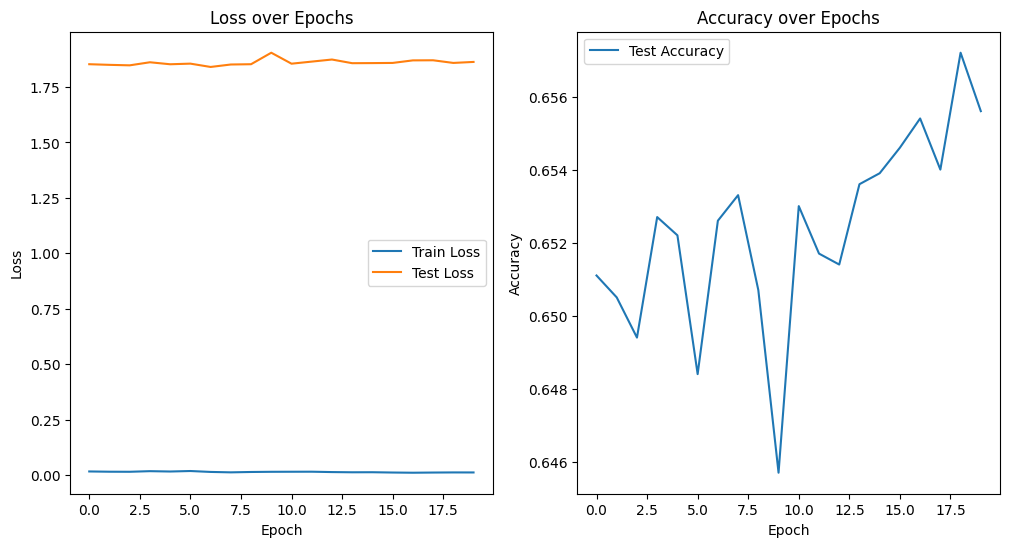

In [30]:
train_losses = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    # 훈련과정에서 손실을 기록
    train_loss = 0
    total_samples = 0
    net.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        total_samples += inputs.size(0)
    
    train_losses.append(train_loss / total_samples)

    # 평가 과정에서 손실과 정확도를 기록
    test_loss = 0
    correct = 0
    total = 0
    net.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_losses.append(test_loss / total)
    test_accuracies.append(correct / total)

# 손실과 정확도 그래프 그리기
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**Top-1 Accuracy**

In [31]:
def calculate_top1_accuracy(model, device, data_loader, criterion):
    model.eval()  # 모델을 평가 모드로 설정
    correct = 0
    total = 0
    
    with torch.no_grad():  # 그래디언트 계산 비활성화
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            # # 각 샘플에 대한 예측 결과와 실제 레이블 출력
            # for i in range(data.size(0)):
            #     print(f"Sample {i + 1}: Predicted = {predicted[i].item()}, Actual = {target[i].item()}")

    top1_accuracy = 100 * correct / total
    print(f"Top-1 Accuracy: {top1_accuracy:.2f}%")

In [32]:
calculate_top1_accuracy(net, device, val_loader, criterion)

Top-1 Accuracy: 65.02%


**Top-5 Accuracy**

In [33]:
def calculate_and_print_top5_accuracy(model, device, data_loader, criterion):
    model.eval()  # 모델을 평가 모드로 설정
    correct = 0
    total = 0
    
    with torch.no_grad():  # 그래디언트 계산 비활성화
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            # Top-5 예측 결과 가져오기
            _, predicted_top5 = torch.topk(outputs, 5, dim=1)
            total += target.size(0)
            
            # 예측된 Top-5 내에 실제 레이블이 있는지 확인
            correct += (predicted_top5 == target.view(-1, 1)).sum().item()

    top5_accuracy = 100 * correct / total
    print(f"Top-5 Accuracy: {top5_accuracy:.2f}%")

In [34]:
calculate_and_print_top5_accuracy(net, device, val_loader, criterion)

Top-5 Accuracy: 87.88%


# Data Analysis - 현욱

In [35]:
# %load_ext tensorboard
# %tensorboard --logdir=./runs/resnet_18/tensorboard --port=8202 --host=0.0.0.0

### **Classes**

In [36]:
classes = train_data.classes
coarse_classes = [
    'aquatic mammals', 'fish', 'flowers', 'food containers', 'fruit and vegetables', 'household electrical devices', 
    'household furniture', 'insects', 'large carnivores', 'large man-made outdoor things', 
    'large natural outdoor scenes', 'large omnivores and herbivores', 'medium-sized mammals', 
    'non-insect invertebrates', 'people', 'reptiles', 'small mammals', 'trees', 'vehicles 1', 'vehicles 2'
]

NameError: name 'train_data' is not defined

In [ ]:
print(len(classes), len(coarse_classes))

##### **Fine_to_coarse_mapping**

In [ ]:
# CIFAR-100 세부 클래스(fine classes)와 상위 클래스(coarse classes) 매핑
fine_to_coarse_mapping = {
    # aquatic mammals
    'beaver': 'aquatic mammals',
    'dolphin': 'aquatic mammals',
    'otter': 'aquatic mammals',
    'seal': 'aquatic mammals',
    'whale': 'aquatic mammals',
    
    # fish
    'aquarium fish': 'fish',
    'flatfish': 'fish',
    'ray': 'fish',
    'shark': 'fish',
    'trout': 'fish',
    
    # flowers
    'orchids': 'flowers',
    'poppies': 'flowers',
    'roses': 'flowers',
    'sunflowers': 'flowers',
    'tulips': 'flowers',
    
    # food containers
    'bottles': 'food containers',
    'bowls': 'food containers',
    'cans': 'food containers',
    'cups': 'food containers',
    'plates': 'food containers',
    
    # fruit and vegetables
    'apples': 'fruit and vegetables',
    'mushrooms': 'fruit and vegetables',
    'oranges': 'fruit and vegetables',
    'pears': 'fruit and vegetables',
    'sweet peppers': 'fruit and vegetables',
    
    # household electrical devices
    'clock': 'household electrical devices',
    'computer keyboard': 'household electrical devices',
    'lamp': 'household electrical devices',
    'telephone': 'household electrical devices',
    'television': 'household electrical devices',
    
    # household furniture
    'bed': 'household furniture',
    'chair': 'household furniture',
    'couch': 'household furniture',
    'table': 'household furniture',
    'wardrobe': 'household furniture',
    
    # insects
    'bee': 'insects',
    'beetle': 'insects',
    'butterfly': 'insects',
    'caterpillar': 'insects',
    'cockroach': 'insects',
    
    # large carnivores
    'bear': 'large carnivores',
    'leopard': 'large carnivores',
    'lion': 'large carnivores',
    'tiger': 'large carnivores',
    'wolf': 'large carnivores',
    
    # large man-made outdoor things
    'bridge': 'large man-made outdoor things',
    'castle': 'large man-made outdoor things',
    'house': 'large man-made outdoor things',
    'road': 'large man-made outdoor things',
    'skyscraper': 'large man-made outdoor things',
    
    # large natural outdoor scenes
    'cloud': 'large natural outdoor scenes',
    'forest': 'large natural outdoor scenes',
    'mountain': 'large natural outdoor scenes',
    'plain': 'large natural outdoor scenes',
    'sea': 'large natural outdoor scenes',
    
    # large omnivores and herbivores
    'camel': 'large omnivores and herbivores',
    'cattle': 'large omnivores and herbivores',
    'chimpanzee': 'large omnivores and herbivores',
    'elephant': 'large omnivores and herbivores',
    'kangaroo': 'large omnivores and herbivores',
    
    # medium-sized mammals
    'fox': 'medium-sized mammals',
    'porcupine': 'medium-sized mammals',
    'possum': 'medium-sized mammals',
    'raccoon': 'medium-sized mammals',
    'skunk': 'medium-sized mammals',
    
    # non-insect invertebrates
    'crab': 'non-insect invertebrates',
    'lobster': 'non-insect invertebrates',
    'snail': 'non-insect invertebrates',
    'spider': 'non-insect invertebrates',
    'worm': 'non-insect invertebrates',
    
    # people
    'baby': 'people',
    'boy': 'people',
    'girl': 'people',
    'man': 'people',
    'woman': 'people',
    
    # reptiles
    'crocodile': 'reptiles',
    'dinosaur': 'reptiles',
    'lizard': 'reptiles',
    'snake': 'reptiles',
    'turtle': 'reptiles',
    
    # small mammals
    'hamster': 'small mammals',
    'mouse': 'small mammals',
    'rabbit': 'small mammals',
    'shrew': 'small mammals',
    'squirrel': 'small mammals',
    
    # trees
    'maple': 'trees',
    'oak': 'trees',
    'palm': 'trees',
    'pine': 'trees',
    'willow': 'trees',
    
    # vehicles 1
    'bicycle': 'vehicles 1',
    'bus': 'vehicles 1',
    'motorcycle': 'vehicles 1',
    'pickup truck': 'vehicles 1',
    'train': 'vehicles 1',
    
    # vehicles 2
    'lawn-mower': 'vehicles 2',
    'rocket': 'vehicles 2',
    'streetcar': 'vehicles 2',
    'tank': 'vehicles 2',
    'tractor': 'vehicles 2'
}


### **Confusion Matrix**

In [ ]:
y_pred = []
y_true = []

# iterate over test data
for x, y in torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size):
    
    #print('iter val', i)
    x = x.to(device)
    y = y.to(device)
    z = net(x)
    _, yhat = torch.max(z, 1)
    pred = yhat.data.cpu().numpy()
    y_pred.extend(pred) # Save Prediction

    labels = y.data.cpu().numpy()
    y_true.extend(labels) # Save Truth

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (128,70))
sns.heatmap(df_cm, annot=True)
plt.title('Confusion Matrix of ResNet (CIFAR100)')
plt.savefig('./runs/resnet_18/Confusion_matrix_ResNet_Cifar100.jpg')

### **Confusion Matrix - Coarse**

### **Classification Report**

In [ ]:
print(f" Classification Report of ResNet(CIFAR100)  \n { classification_report(y_true, y_pred)}")

In [ ]:
# Save Classification Report as txt file 
with open("./runs/resnet_18/cr_ResNet18.txt", "w") as text_file:
    print(classification_report(y_true, y_pred, digits=4), file=text_file)

In [ ]:
# Load Classification Report txt file 
with open("./runs/resnet_18/cr_ResNet18.txt", "r") as f:
  cr = f.read()
print(cr)